In [19]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Bidirectional, Dropout, Activation, Dense, LSTM
from tensorflow.python.keras.layers import CuDNNLSTM
from tensorflow.keras.models import Sequential

%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 14, 8

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)

In [51]:
crypto = pd.read_csv("consolidated_coin_data.csv", parse_dates=['Date'])

In [52]:
crypto_btc = crypto[crypto['Currency'] == "bitcoin"]

In [53]:
crypto_btc.head()

,Currency,Date,Open,High,Low,Close,Volume,Market Cap
7236,bitcoin,2019-12-04,7320.13,7539.78,7170.92,7252.03,21664240918,1.311430e+11
7237,bitcoin,2019-12-03,7323.98,7418.86,7229.36,7320.15,14797485769,1.323600e+11
7238,bitcoin,2019-12-02,7424.04,7474.82,7233.40,7321.99,17082040706,1.323790e+11
7239,bitcoin,2019-12-01,7571.62,7571.62,7291.34,7424.29,18720708479,1.342150e+11
7240,bitcoin,2019-11-30,7764.06,7836.10,7515.85,7569.63,17158194786,1.368290e+11


### Bitcoin

In [54]:
crypto_btc = crypto_btc.sort_values('Date')

In [55]:
crypto_btc.shape

(2412, 8)

''

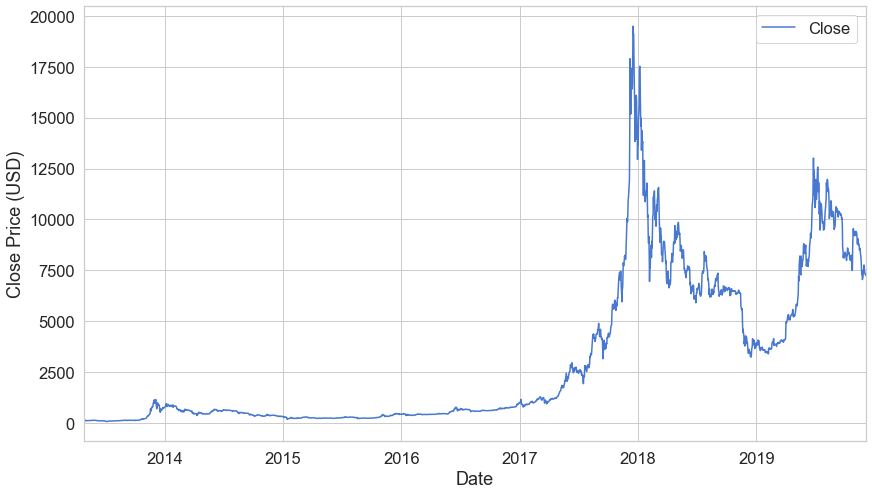

In [56]:
ax = crypto_btc.plot(x='Date', y='Close')
ax.set_xlabel("Date")
ax.set_ylabel("Close Price (USD)")
;


In [57]:
scaler = MinMaxScaler()

close_price = crypto_btc.Close.values.reshape(-1, 1)

scaled_close = scaler.fit_transform(close_price)

In [58]:
scaled_close

array([[0.00338567],
       [0.00391735],
       [0.0036322 ],
       ...,
       [0.37333734],
       [0.37324264],
       [0.36973653]])

In [59]:
np.isnan(scaled_close).any()

False

In [60]:
scaled_close = scaled_close[~np.isnan(scaled_close)]

In [61]:
scaled_close = scaled_close.reshape(-1, 1)

In [62]:
np.isnan(scaled_close).any()

False

Preprocessing

In [63]:
SEQ_LEN = 100

def to_sequences(data, seq_len):
    d = []

    for index in range(len(data) - seq_len):
        d.append(data[index: index + seq_len])

    return np.array(d)

def preprocess(data_raw, seq_len, train_split):

    data = to_sequences(data_raw, seq_len)

    num_train = int(train_split * data.shape[0])

    X_train = data[:num_train, :-1, :]
    y_train = data[:num_train, -1, :]

    X_test = data[num_train:, :-1, :]
    y_test = data[num_train:, -1, :]

    return X_train, y_train, X_test, y_test


X_train, y_train, X_test, y_test = preprocess(scaled_close, SEQ_LEN, train_split = 0.95)

In [64]:
X_train.shape

(2196, 99, 1)

In [65]:
y_train.shape

(2196, 1)

In [66]:
X_test.shape

(116, 99, 1)

In [67]:
y_test.shape

(116, 1)

### Model

In [68]:
#The network has a visible layer with 1 input, a hidden layer with 4 LSTM blocks or neurons, 
#and an output layer that makes a single value prediction. 
#The default sigmoid activation function is used for the LSTM blocks. 
#The network is trained for 15 epochs and a batch size of 32 is used.


model = Sequential()
#We add the LSTM layer with the following arguments:
#100 units which is the dimensionality of the output space
#return_sequences=True which determines whether to return the last output in the output sequence,
#or the full sequence
#input_shape as the shape of our training set.
model.add(LSTM(units=100, return_sequences=True, input_shape=(X_train.shape[1], 1)))

#We add the LSTM layer and later add a few Dropout layers to prevent overfitting. 

model.add(Dropout(0.2))
model.add(LSTM(units=100, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=100, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=100))
model.add(Dropout(0.2))
model.add(Dense(units=1))

In [69]:
model.compile(
    loss='mean_squared_error', 
    optimizer='adam'
)

### Epoch 15

In [70]:
BATCH_SIZE = 64

history = model.fit(
    X_train, 
    y_train, 
    epochs=15, 
    batch_size=BATCH_SIZE
)

Train on 2196 samples
Epoch 1/15
2196/2196 [==============================] - 18s 8ms/sample - loss: 0.0088
Epoch 2/15
2196/2196 [==============================] - 21s 9ms/sample - loss: 0.0028
Epoch 3/15
2196/2196 [==============================] - 20s 9ms/sample - loss: 0.0021
Epoch 4/15
2196/2196 [==============================] - 23s 10ms/sample - loss: 0.0019
Epoch 5/15
2196/2196 [==============================] - 24s 11ms/sample - loss: 0.0020
Epoch 6/15
2196/2196 [==============================] - 21s 9ms/sample - loss: 0.0015
Epoch 7/15
2196/2196 [==============================] - 21s 9ms/sample - loss: 0.0012
Epoch 8/15
2196/2196 [==============================] - 21s 10ms/sample - loss: 0.0014
Epoch 9/15
2196/2196 [==============================] - 22s 10ms/sample - loss: 0.0014
Epoch 10/15
2196/2196 [==============================] - 21s 10ms/sample - loss: 0.0012
Epoch 11/15
2196/2196 [==============================] - 21s 10ms/sample - loss: 0.0012
Epoch 12/15
2196/2196 [=

In [71]:
model.evaluate(X_test, y_test)

116/116 [==============================] - 1s 11ms/sample - loss: 0.0011


0.0010809249300830837

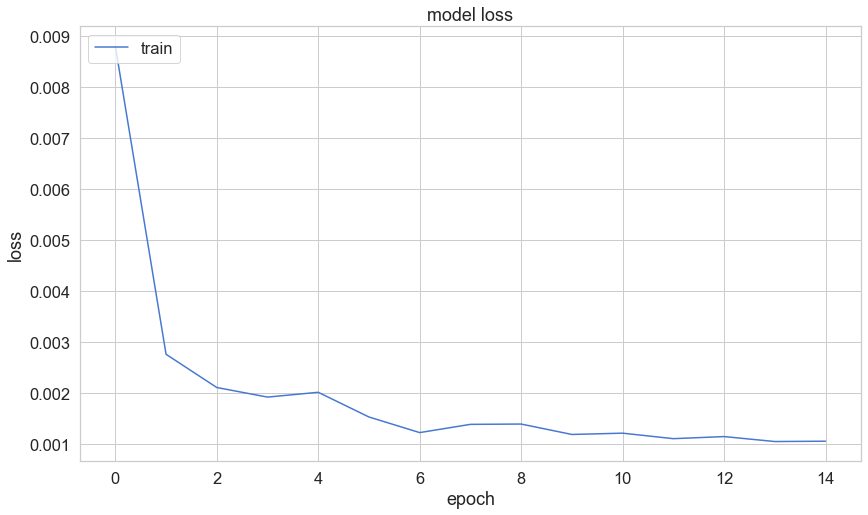

In [73]:
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

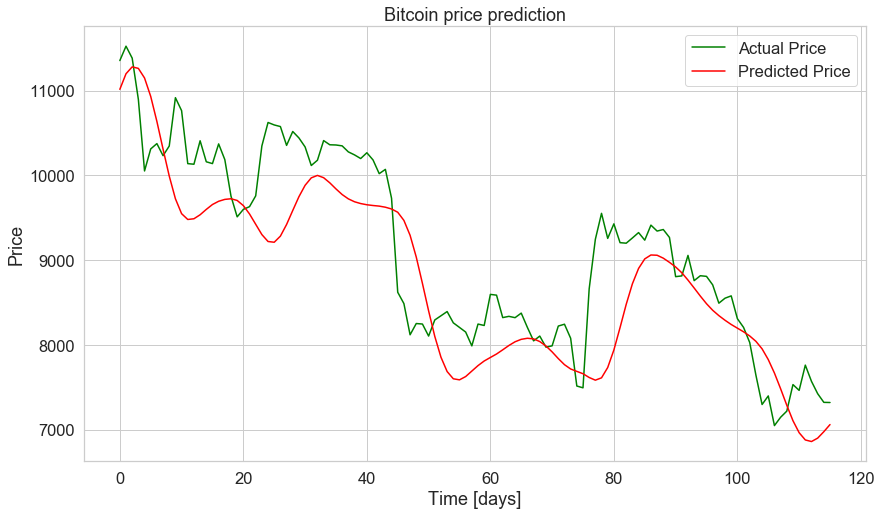

In [74]:
y_hat = model.predict(X_test)

y_test_inverse = scaler.inverse_transform(y_test)
y_hat_inverse = scaler.inverse_transform(y_hat)
 
plt.plot(y_test_inverse, label="Actual Price", color='green')
plt.plot(y_hat_inverse, label="Predicted Price", color='red')
 
plt.title('Bitcoin price prediction')
plt.xlabel('Time [days]')
plt.ylabel('Price')
plt.legend(loc='best')
 
plt.show();

### Epoch 50

In [75]:
BATCH_SIZE = 64

history = model.fit(
    X_train, 
    y_train, 
    epochs=50, 
    batch_size=BATCH_SIZE
)

Train on 2196 samples
Epoch 1/50
2196/2196 [==============================] - 19s 9ms/sample - loss: 8.8594e-04
Epoch 2/50
2196/2196 [==============================] - 24s 11ms/sample - loss: 9.8920e-04
Epoch 3/50
2196/2196 [==============================] - 24s 11ms/sample - loss: 9.0765e-04
Epoch 4/50
2196/2196 [==============================] - 24s 11ms/sample - loss: 9.9037e-04
Epoch 5/50
2196/2196 [==============================] - 23s 11ms/sample - loss: 0.0012
Epoch 6/50
2196/2196 [==============================] - 24s 11ms/sample - loss: 8.3879e-04
Epoch 7/50
2196/2196 [==============================] - 24s 11ms/sample - loss: 8.4427e-04
Epoch 8/50
2196/2196 [==============================] - 23s 11ms/sample - loss: 9.1529e-04
Epoch 9/50
2196/2196 [==============================] - 23s 11ms/sample - loss: 7.9842e-04
Epoch 10/50
2196/2196 [==============================] - 23s 11ms/sample - loss: 8.8031e-04
Epoch 11/50
2196/2196 [==============================] - 23s 11ms/sample

In [76]:
model.evaluate(X_test, y_test)

116/116 [==============================] - 0s 3ms/sample - loss: 7.1751e-04


0.0007175106709774841

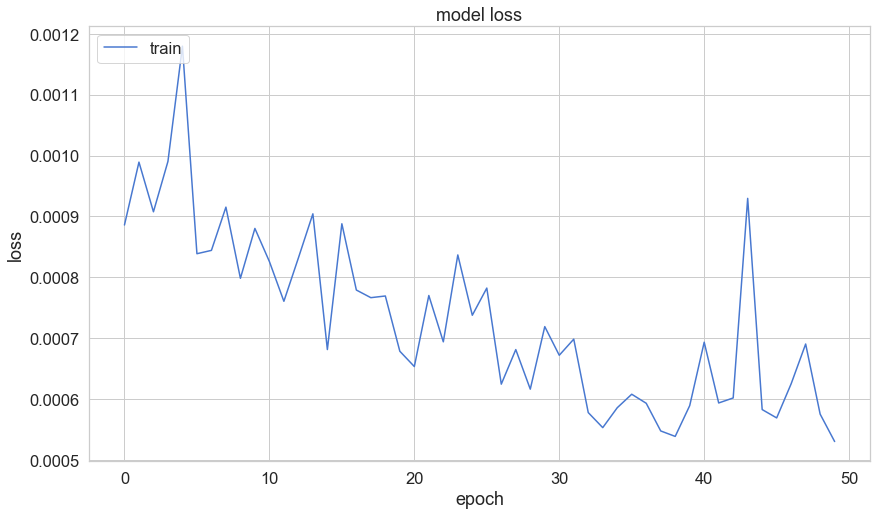

In [77]:
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

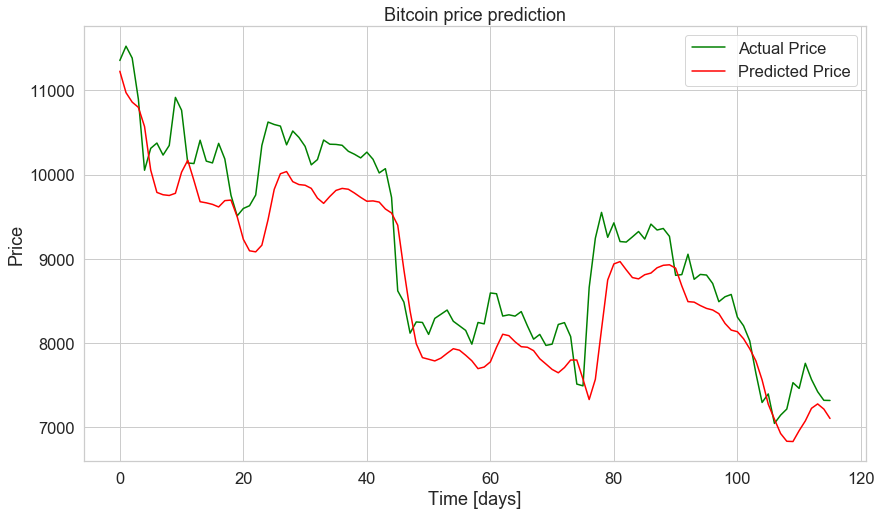

In [78]:
y_hat = model.predict(X_test)

y_test_inverse = scaler.inverse_transform(y_test)
y_hat_inverse = scaler.inverse_transform(y_hat)
 
plt.plot(y_test_inverse, label="Actual Price", color='green')
plt.plot(y_hat_inverse, label="Predicted Price", color='red')
 
plt.title('Bitcoin price prediction')
plt.xlabel('Time [days]')
plt.ylabel('Price')
plt.legend(loc='best')
 
plt.show();